In [2]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py, emoji
from tqdm import tqdm
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from mpl_toolkits.axes_grid.inset_locator import inset_axes

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal
from glob import glob 
from pprint import pprint
from mpltools import color

%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


# Trapped electrons for different reservoir densities and different $V_{trap}^{park}$

In [47]:
save_path = r"/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Trap signal exploration"
sub_dirs = glob(os.path.join(save_path, "170712*"))
# pprint([os.path.split(sub_dirs[k])[1] for k in range(len(sub_dirs))])

['/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/Trap signal '
 'exploration/170712_132553_M018V6_Electron_Number_Plot_resonator_sweep',
 '/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/Trap signal '
 'exploration/170712_134045_M018V6_Electron_Number_Plot_resonator_sweep',
 '/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/Trap signal '
 'exploration/170712_140046_M018V6_Electron_Number_Plot_resonator_sweep',
 '/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/Trap signal '
 'exploration/170712_142053_M018V6_Electron_Number_Plot_resonator_sweep',
 '/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/Trap signal '
 'exploration/170712_145954_M018V6_Electron_Number_Plot_resonator_sweep',
 '/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/Trap signal '
 'exploration/1707

In [76]:
Vtraps = list()
num_electrons = list()
num_total_electrons = list()
e_density = list()
trap_domain_x = (18.5E-6, 21.5E-6)

for sub_dir in sub_dirs:
    converged, energy, num_trapped_electrons = list(), list(), list()
    with h5py.File(os.path.join(os.path.join(save_path, sub_dir), "Results.h5"), "r") as f:
        print("Directory: %s" % sub_dir)
        k = 0

        resVs, trapVs, resgVs, trapgVs = f["Vres"][()], f["Vtrap"][()], f["Vrg"][()], f["Vtg"][()]
        Vtraps.append(np.max(trapVs))
        
        for step in f.keys():
            if "step" in step:
                electron_ri = f[step + "/electron_final_coordinates"][()]
                xi, yi = anneal.r2xy(electron_ri)
                energy.append(f[step+"/final_energy"][()])

                valid_solution = f[step + "/solution_converged"][()]
                converged.append(valid_solution)
                if k == 0:
                    num_total_electrons.append(len(xi))
                    xi_resonator = xi[xi > 21E-6]
                    yi_resonator = yi[xi > 21E-6]
                    e_density.append(anneal.get_electron_density_by_position(anneal.xy2r(xi_resonator, yi_resonator)))
                    
                k += 1
                
                num_trapped_electrons.append(np.sum(np.logical_and(xi < trap_domain_x[1], xi > trap_domain_x[0])))
        
        num_electrons.append(num_trapped_electrons)
        

Directory: /Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Trap signal exploration/170712_132553_M018V6_Electron_Number_Plot_resonator_sweep
Directory: /Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Trap signal exploration/170712_134045_M018V6_Electron_Number_Plot_resonator_sweep
Directory: /Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Trap signal exploration/170712_140046_M018V6_Electron_Number_Plot_resonator_sweep
Directory: /Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Trap signal exploration/170712_142053_M018V6_Electron_Number_Plot_resonator_sweep
Directory: /Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Trap signal exploration/170712_145954_M018V6_Electron_Number_Plot_resonator_sweep
Directory: /Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Trap signal exploration/170712_1

/Users/gkoolstra/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


1.24202801906e+13
1.38587434583e+13
1.42200206285e+13
1.22951938571e+13
1.35171143139e+13
1.39564301829e+13
1.22325299853e+13
1.30782036845e+13
1.41469920854e+13
1.22961312727e+13
1.28511239544e+13
1.42275014982e+13


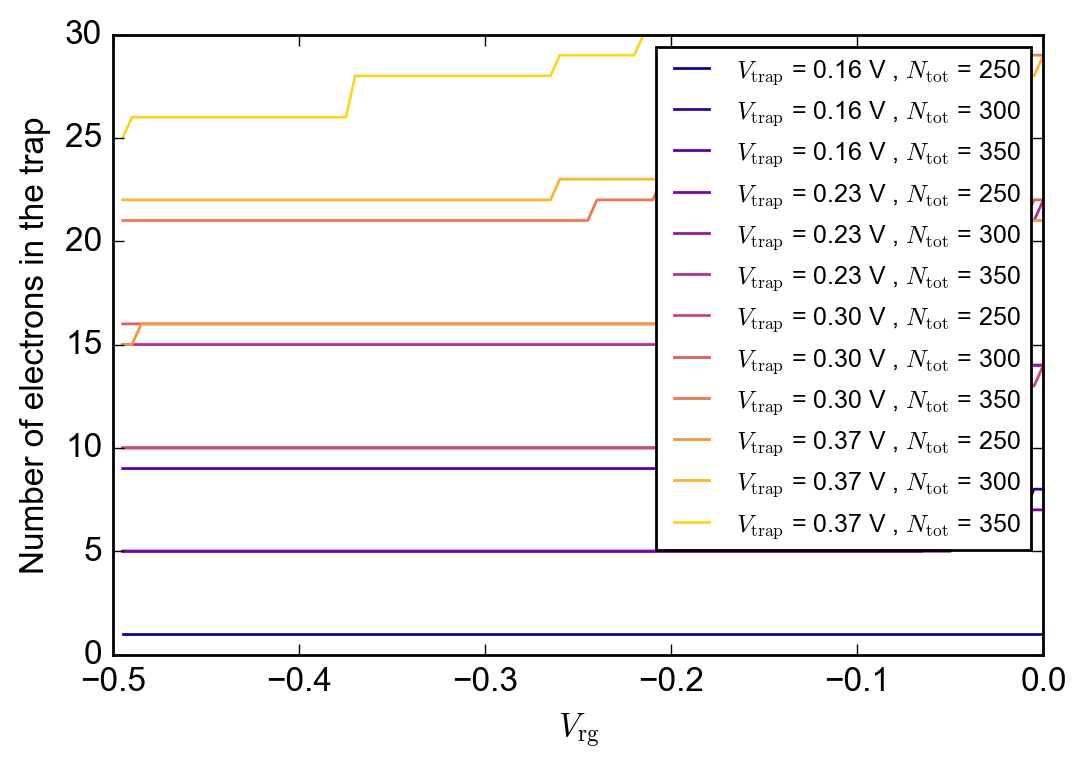

In [77]:
N=np.array(num_electrons)

plt.figure()
color.cycle_cmap(np.shape(N)[0]+1, cmap=plt.cm.plasma)
common.configure_axes(12)

ind = np.lexsort((num_total_electrons, Vtraps))

for k in ind:
    Vtraps
    plt.plot(resgVs, N[k,:], 
             label=r"$V_\mathrm{trap}$ = %.2f V , $N_\mathrm{tot}$ = %d"%(Vtraps[k], num_total_electrons[k]))
#     print(e_density[k])
    
plt.ylim(0, 30)
plt.ylabel("Number of electrons in the trap")
plt.xlabel("$V_\mathrm{rg}$")
plt.legend(loc=0, prop={"size": 9})

In [119]:
import matplotlib
def rgba(i, N):
    norm = matplotlib.colors.Normalize(vmin=0, vmax=N)
    cmap = plt.cm.plasma
    m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    return m.to_rgba(i)

fig = plt.figure()

for i,k in enumerate(ind):
    if not(i%3): 
        label=r"$V_\mathrm{trap}$ = %.2f V"%(Vtraps[k])
    else:
        label=""
    plt.plot(num_total_electrons[k], N[k,-1], 'o', label=label, color=rgba(i, len(ind)))
    
plt.ylim(0, 30)
plt.title("Number of electrons in the trap at $V_\mathrm{rg}$ = %.3f V"%resgVs[-1])
plt.xlabel("Number of electrons in the system")
plt.ylabel("$N$")
plt.legend(loc=0, prop={"size": 9}, numpoints=1)

# common.save_figure(fig, save_path=r"/Users/gkoolstra/Documents/Code/iPythonNotebooks/Figures")

NameError: name 'ind' is not defined

# Full $V_\mathrm{trap}^{\mathrm{park}}$ sweep for $N=250$

In [250]:
save_path = r"/Users/gkoolstra/Desktop/Electron on Helium Fast ResG Sweep"
sub_dirs = glob(os.path.join(save_path, "*Fast_Rg_Sweep*"))
# pprint([os.path.split(sub_dirs[k])[1] for k in range(len(sub_dirs))])

29it [03:59,  8.07s/it]


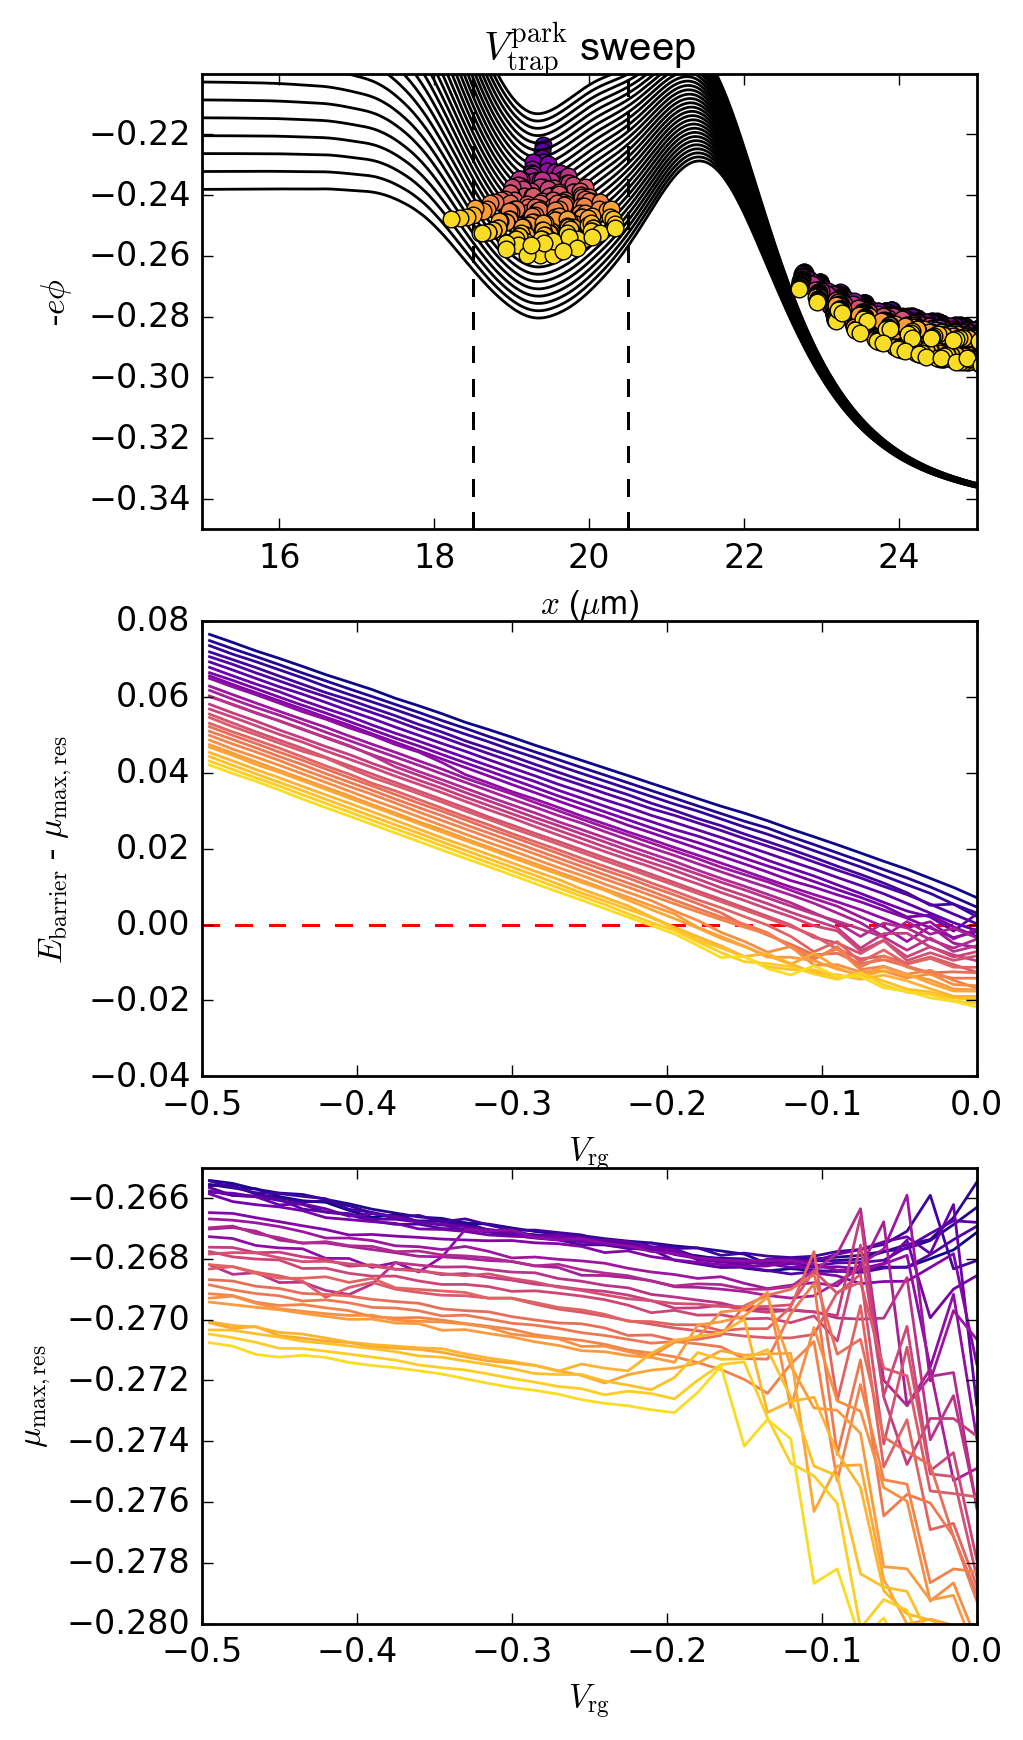

In [251]:
fig=plt.figure(figsize=(5.,10))
common.configure_axes(12)

Vtrap_parks = list()
Resg_good_trap = list()
num_electrons = list()

for l, sub_dir in tqdm(enumerate(sub_dirs[:-1])):
    Vtraps = list()
    num_total_electrons = list()
    e_density = list()
    xis_resonator = list()
    mus, xis, cut, x_cut = list(), list(), list(), list()
    trap_domain_x = (18.5E-6, 20.5E-6)

    converged, energy, num_trapped_electrons = list(), list(), list()
    with h5py.File(os.path.join(save_path, sub_dir, "Results.h5"), "r") as f:
#         print("Directory: %s" % os.path.split(sub_dir)[1])
        k = 0

        resVs, trapVs, resgVs, trapgVs = f["Vres"][()], f["Vtrap"][()], f["Vrg"][()], f["Vtg"][()]
        Vtraps.append(np.max(trapVs))
        
        for i, step in enumerate(f.keys()):
            if "step" in step:
                potential = resVs[k] * f["resonator"][()] + trapVs[k] * f["trap"][()] + resgVs[k] * f["res_guard"][()] \
                            + trapgVs[k] * f["trap_guard"][()]
                yidx = common.find_nearest(f["ypoints"][()][:,0], 0.0)
                cut.append(potential[yidx,:])
                x_cut.append(f["xpoints"][()][yidx,:])
                
                electron_ri = f[step + "/electron_final_coordinates"][()]
                xi, yi = anneal.r2xy(electron_ri)
                energy.append(f[step+"/final_energy"][()])
                mus.append(f[step+"/mu"][()])
                xis.append(xi)
                xis_resonator.append(xi[xi > 21.5E-6])

                valid_solution = f[step + "/solution_converged"][()]
                converged.append(valid_solution)
                if k == 0:
                    num_total_electrons.append(len(xi))
                    xi_resonator = xi[xi > 21.5E-6]
                    yi_resonator = yi[xi > 21.5E-6]
                    e_density.append(anneal.get_electron_density_by_position(anneal.xy2r(xi_resonator, yi_resonator)))
                    
                k += 1
                
                num_trapped_electrons.append(np.sum(np.logical_and(xi < trap_domain_x[1], xi > trap_domain_x[0])))
        
        num_electrons.append(num_trapped_electrons)

    xis = np.array(xis)
    xis_resonator = np.array(xis_resonator)
    mus = np.array(mus)
    cut = np.array(cut)
    x_cut = np.array(x_cut)
    
    separated, max_res_electron_energy, barrier_heights = list(), list(), list()
    selection = np.arange(np.shape(xis)[0])[::3] 
    Vtrap_parks.append(np.max(trapVs))

#     plt.figure(figsize=(5.,10))
    plt.subplot(311)
    for i, idx in enumerate(selection):
        if idx==selection[-1]:
            plt.plot(xis[idx,:]*1E6, mus[idx,:], 'o', color=rgba(l, len(sub_dirs)))
            ymin, ymax = -0.35, -np.max(trapVs)*0.50
            plt.vlines([trap_domain_x[0]*1E6, trap_domain_x[1]*1E6], ymin, ymax, linestyles='--', color='k')
            plt.plot(x_cut[idx,:]*1E6, cut[idx,:], color='k')
            plt.ylim(ymin, ymax)
            plt.xlim(15, 25)
            plt.xlabel("$x$ ($\mu$m)")
            plt.ylabel("-$e\phi$")
            plt.title("$V_\mathrm{trap}^\mathrm{park}$ sweep")

        closest_resonator_electron = xis_resonator[idx][common.find_nearest(xis_resonator[idx], 21.5E-6)]
        closest_resonator_electron_mu = mus[idx, common.find_nearest(xis[idx,:], closest_resonator_electron)]
        x_bar_min = common.find_nearest(x_cut[idx,:], 21E-6)
        x_bar_max = common.find_nearest(x_cut[idx,:], 22E-6)
        x_trap_min = common.find_nearest(x_cut[idx,:], trap_domain_x[0])
        x_trap_max = common.find_nearest(x_cut[idx,:], trap_domain_x[1])
        barrier_heights.append(np.max(cut[idx,x_bar_min:x_bar_max]))
        trap_level = np.min(cut[idx, x_trap_min:x_trap_max])
    
        if i==selection[-1]:
            plt.hlines(closest_resonator_electron_mu, 15, 25, linestyles='--', color='red')
        separated.append(np.logical_and(barrier_heights[i]>closest_resonator_electron_mu, 
                                        barrier_heights[i]>trap_level))
        max_res_electron_energy.append(closest_resonator_electron_mu)

    rg_sep = resgVs[selection][np.where(np.diff(separated)==1)[0]]
    rg_sep = rg_sep if len(rg_sep) > 0 else 0.00
    Resg_good_trap.append(rg_sep)
#     print("\tTrap and reservoir are well separated for Vrg < %.3f"%(rg_sep))

    plt.subplot(312)
    plt.plot(resgVs[selection], np.array(barrier_heights) - np.array(max_res_electron_energy), 
             '-', color=rgba(l, len(sub_dirs)))
    plt.hlines(0.00, np.min(resgVs), np.max(resgVs), linestyles='--', color='r')
    plt.xlabel("$V_\mathrm{rg}$")
    plt.ylabel("$E_\mathrm{barrier}$ - $\mu_\mathrm{max, res}$")

    plt.subplot(313)
    plt.plot(resgVs[selection], np.array(max_res_electron_energy), '-', color=rgba(l, len(sub_dirs)))
    plt.xlabel("$V_\mathrm{rg}$")
    plt.ylabel("$\mu_\mathrm{max, res}$")
    ymin, ymax = plt.ylim()
#     plt.vlines(rg_sep, ymin, ymax, linestyles='--', color='r' )
    plt.ylim(-0.28, -0.265)
    
common.save_figure(fig, save_path=r"/Users/gkoolstra/Documents/Code/iPythonNotebooks/Figures")

The meaning of the three plots is as follows
- The top plot shows the final configuration at $V_{rg}=-0.50$V for different trap loading voltages. The electrostatic potential is displayed in black. It's clear that there's a threshold that determines when you can load electrons in the trap.
- The second plot shows the barrier height minus the highest energy electron on the resonator. If positive, the chemical potential lies below the barrier. If negative, the trap and reservoir are connected. The points of intersection should roughly follow the curve we calculated from just the electrostatic potential, with $\mu=-0.267$ (value from bottom plot).
- The bottom plot shows the energy of the electron closest to the barrier to the resonator as a function of $V_\mathrm{rg}$ for different trap loading voltages. At the same time, we assume that this is the electron with the highest energy on the resonator (due to the sloped profile of the resonator). This energy changes slightly with $V_{rg}$, because the trap electrode changes the electrostatic potential (included in $\mu$). The spikes at $V_{rg} \approx 0$ are due a very flat electrostatic potential near the trap. Electrons jump in and out of the trap easily, resulting in a bit of noise. At $V_{rg} = -0.50$ the spread in $\mu$ is small. This data was for $N=250$ electrons on the resonator.

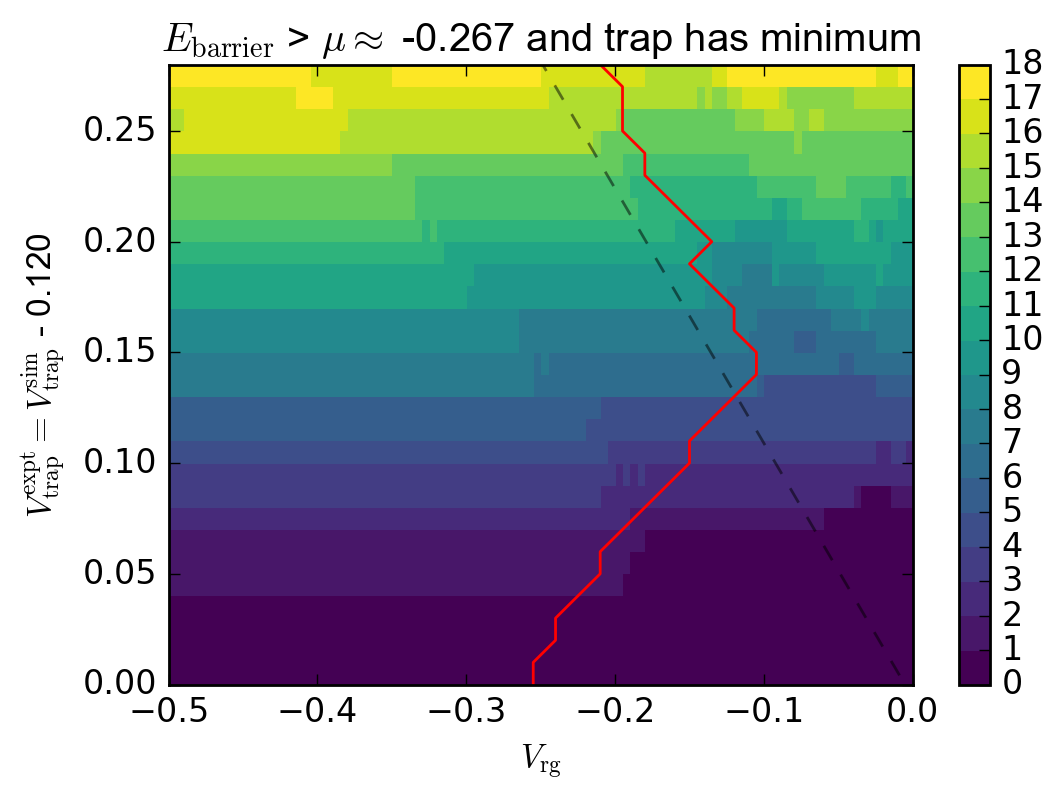

In [286]:
fig = plt.figure()
common.configure_axes(12)
plt.pcolormesh(resgVs, np.array(Vtrap_parks)-0.120, np.array(num_electrons), 
               cmap=plt.cm.get_cmap("viridis", np.max(np.array(num_electrons))), 
               vmin=0, vmax=np.max(np.array(num_electrons)))
plt.plot(np.array(Resg_good_trap).flatten(), np.array(Vtrap_parks)-0.120, '-', color='r')
plt.ylabel(r"$V_\mathrm{trap}^\mathrm{expt} = V_\mathrm{trap}^\mathrm{sim}$ - 0.120")
plt.xlabel(r"$V_\mathrm{rg}$")
plt.title(r"$E_\mathrm{barrier}$ > $\mu \approx$ -0.267 and trap has minimum")
plt.xlim(-0.5, 0.0)
plt.ylim(0.00, 0.28)

cbar = plt.colorbar()
cbar.set_ticks(range(0, np.max(num_electrons)+1))

xdata = np.array(Resg_good_trap).flatten()
ydata = np.array(Vtrap_parks)

# fr, ferr = kfit.fit_poly(xdata, ydata, fitparams=[0,1])
# plt.plot(xdata, kfit.polyfunc(xdata, *fr), color='k')

x = np.linspace(-0.30, 0.00, 101)
f_mu = -1.755-7*mu
plt.plot(x, -1.15*x + f_mu - 0.120, '--', color='k', alpha=0.5)

common.save_figure(fig, save_path=r"/Users/gkoolstra/Documents/Code/iPythonNotebooks/Figures")

The red line are points for which the following two conditions are met:
- On this line, the barrier height is equal to the highest energy electron for that particular configuration at that particular point in ($V_\mathrm{rg}, V_\mathrm{trap}$) space.
- Secondly, the trap has a dimple separating the trap from the reservoir.

Therefore, to the _left_ of these points it is possible to trap electrons separately from the resonator (reservoir) electrons. It turns out that this line is quite similar to the equal barrier height curve 0.00 that we have calculated in the `Master simulation notebook`. The fact that these are different (offset ~ 50 mV) is understandable, because here we've calculated it taking into account the electrons, and their energies. The fact that these are similar is good, because it means we can deduce most of the physics from looking at the electrostatic potential!

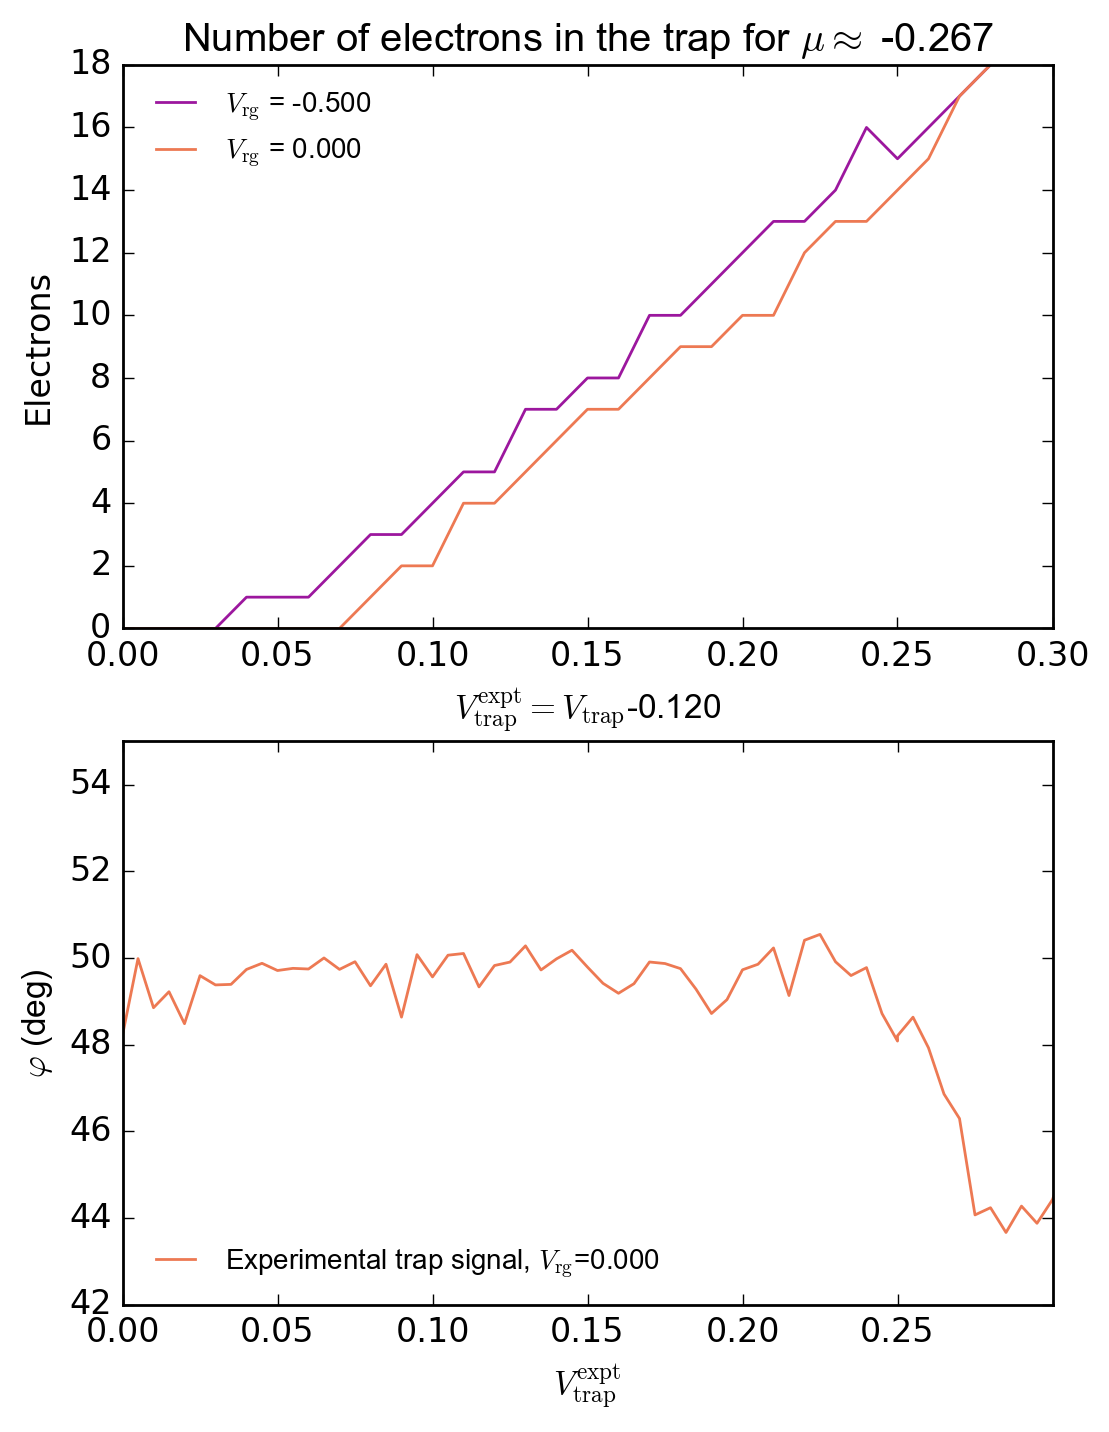

In [289]:
fig=plt.figure(figsize=(6.,8.))
plt.subplot(211)
plt.plot(np.array(Vtrap_parks)-0.120, np.array(num_electrons)[:,-1], color=rgba(1,3), 
         label="$V_\mathrm{rg}$ = %.3f"%(resgVs[-1]))
plt.plot(np.array(Vtrap_parks)-0.120, np.array(num_electrons)[:,0], color=rgba(2,3), 
         label="$V_\mathrm{rg}$ = %.3f"%(resgVs[0]))
plt.legend(loc=0, prop={'size' : 10}, frameon=False)
plt.xlabel("$V_\mathrm{trap}^\mathrm{expt}=V_\mathrm{trap}$-0.120")
plt.ylabel("Electrons")
plt.title(r"Number of electrons in the trap for $\mu \approx$ -0.267")

filename=r'/Volumes/slab/_Data/170422 - EonHe M018V6 with L3 etch/data/170723/162136_determine_mu/162136_determine_mu copy.h5'
with h5py.File(filename, "r") as f:
    phases = f['phases'][()]
    vtrap = f['Vtrap'][()]
    
plt.subplot(212)
plt.plot(vtrap, np.mean(phases, axis=1), color=rgba(2,3), label=r"Experimental trap signal, $V_\mathrm{rg}$=0.000")
plt.xlabel(r"$V_\mathrm{trap}^{\mathrm{expt}}$")
plt.ylabel(r"$\varphi$ (deg)")
plt.xlim(0, 0.3)
plt.ylim(42, 55)
plt.legend(loc=0, prop={'size' : 10}, frameon=False)

common.save_figure(fig, save_path=r"/Users/gkoolstra/Documents/Code/iPythonNotebooks/Figures")